In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
messages_df = pd.concat(
    (pd.read_csv('chat_messages_1.csv',low_memory=False),
     pd.read_csv('chat_messages_2.csv',low_memory=False))
    ).dropna()
alliance_dataframe = pd.read_csv('alliance_membership.csv',low_memory=False).dropna()

In [3]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362766 entries, 0 to 182827
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   account_id                   362766 non-null  object 
 1   alliance_id                  362766 non-null  object 
 2   timestamp                    362766 non-null  object 
 3   date                         362766 non-null  object 
 4   raw_message                  362766 non-null  object 
 5   filtered_message             362766 non-null  object 
 6   filtered                     362766 non-null  object 
 7   filtered_content             362766 non-null  object 
 8   risk                         362766 non-null  object 
 9   filter_detected_language     362766 non-null  object 
 10  is_family_friendly           362766 non-null  object 
 11  GENERAL_RISK                 362766 non-null  object 
 12  BULLYING                     362766 non-null  object 
 13 

## Find triggered messages

In [4]:
dictionnary_account = np.array(["snap", "snapchat", "insta", "instagram", "skype", "omegle", "zoom", "@?", "@ ?", "whatsapp", "adress", "phone number", "phonenumber", "vk", "discord"])
dictionnary_compliments = np.array(["cutie", "horny", "sweetheart", "sweety"])
dictionnary_relationship = np.array(["boyfriend", "girlfriend", "relationship","cuddle"])

dictionnary_trigger = np.concatenate([
    dictionnary_account,
    dictionnary_compliments,
    dictionnary_relationship
])

def is_risky(message):
    words = np.array(message.split())
    for word in words:
        if word.lower() in dictionnary_trigger:
            return 1
    return 0

In [5]:
messages_df['trigger'] = messages_df['raw_message'].apply(is_risky)
messages_df['msg_len'] = messages_df['raw_message'].apply(lambda x:len(x))

## Get alliance conversation for every trigger
create a df per alliance and sort each df by date

In [6]:
alliance_ids_triggered = messages_df.loc[messages_df['trigger']==1]["alliance_id"].drop_duplicates()
triggered_alliances_df = [messages_df.loc[messages_df['alliance_id']==alliance].sort_values(by=["timestamp"], ignore_index=True) for alliance in alliance_ids_triggered]
print("Number of problematic alliances:", len(triggered_alliances_df))

Number of problematic alliances: 175


In [53]:
#Exemples of alliances with problematic conversations
#Relationships: 11, 34 (with explicit content), 47, 54, 86
#Asking for pictures: 12->178, 53->69
#Messages that went unfiltered: 15->82, 18->31, 51->1
#Invitation to external networks: 17->194, 37->195

temp = triggered_alliances_df[37]
print(temp['raw_message'].iloc[195])
print(temp.loc[temp['trigger']==1].index)
print(temp[["account_id","raw_message","trigger","RELATIONSHIP_SEXUAL_CONTENT","CHILD_GROOMING"]])

I don't got snap
Int64Index([40, 192, 195, 200, 201, 203, 204], dtype='int64')
                                            account_id  \
0    5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
1    5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
2    5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
3    2ded9f01879b5fd1e97ee0378dabfbe7d76a19a9be712c...   
4    2ded9f01879b5fd1e97ee0378dabfbe7d76a19a9be712c...   
5    5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
6    a83d25f11239a35e1290dc1827e3ecf7ecd3b48be596ef...   
7    5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
8    2ded9f01879b5fd1e97ee0378dabfbe7d76a19a9be712c...   
9    5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
10   5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
11   5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
12   5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
13   5dfcf6275df50d2b50877c02c369d538c235ca20808545...   
14   5dfcf6275df50d2b50877c02c369d538c235ca20808545

# Token charge model
## Build suspect features for model 

2 Token charge model - harder check because less data

	Each elements will add a certain 

	Elements fixes courts termes et long terme

		Fixe:

			- give account 

			- Ask age DATA

			- Young age with old age

		Short term:

			- Asks a lot a messages in a row before an answer DATA

		Long term: 

			- change often alliances DATA

			- Send same first message everytime DATA

			- temps avant de se faire report depuis qu'il join une alliance DATA

In [8]:
#GENERAL FUCNTIONS

def get_alliance_conv(alliance_id):
    if not (alliance_id in messages_df['alliance_id'].values):
        return None
    alliance_df = messages_df[messages_df['alliance_id'] == alliance_id]
    return alliance_df


def get_alliance_conv_triggered(alliance_id):
    for df in triggered_alliances_df:
        if (df.iloc[0]['alliance_id'] == alliance_id):
            return df 
        
def msg_len_to_class(msg_len):
    if msg_len < 10:
        return 0
    if msg_len < 25:
        return 1
    if msg_len < 50:
        return 2
    if msg_len < 100:
        return 3
    return 4

In [9]:
# FEATURES ON MESSAGES

def is_msg_suspect_with_dictionnary(message, dic_to_check):
    dictionnary = dic_to_check
    words = np.array(message.split())
    tresh = 2
    for word in words:
        if word.lower() in dictionnary:
            tresh-=1
    if tresh<=0:
        return 1
    return 0

def check_message_ask_age(msg):
    # go with the dictionnary value through the message and check if the message the value matches one sequence of the message
    # in the dictionary give me different to ask for age
    dic = ["old", "age", "age", "agee", "young", "born"]
    return is_msg_suspect_with_dictionnary(msg,dic)

def check_message_account(msg):
    return is_msg_suspect_with_dictionnary(msg,dictionnary_account)

def check_message_compliment(msg):
    return is_msg_suspect_with_dictionnary(msg,dictionnary_compliments)

def check_message_relationship(msg):
    return is_msg_suspect_with_dictionnary(msg,dictionnary_relationship)

def count_triggers_in_alliance_conv(alliance_id):
    alliance_conv = get_alliance_conv(alliance_id)
    return alliance_conv['trigger'].sum()

def count_triggers_account(account):
    messages_account = messages_df[messages_df['account_id']==account]
    return messages_account['trigger'].sum()

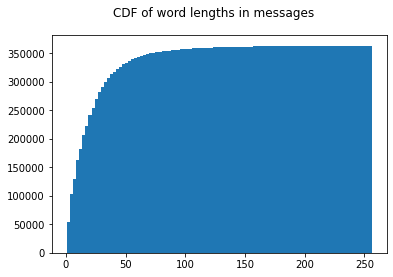

In [10]:
#FUNCTIONS ON ACCOUNTS

from datetime import timedelta

TOTAL_TIME_DATA = timedelta(days=1)

def nb_of_alliance_changes(account):
    his_alliances = messages_df[messages_df['account_id'] == account]['alliance_id'].drop_duplicates()
    return len(his_alliances)

def often_change_alliance(account,often_timedata):
    his_alliances = messages_df[messages_df['account_id'] == account]
    nb_all = nb_of_alliance_changes(account)
    if nb_all==1:
        return 0
    else:
        nb_time_per_total = TOTAL_TIME_DATA.total_seconds() / often_timedata.total_seconds()
        nb_changes_per_day = int(np.ceil(nb_time_per_total))
        return nb_all> nb_changes_per_day

        
def msgs_length_in_conv(account):
    his_alliances = messages_df[messages_df['account_id'] == account]['alliance_id']
    msg_len_cls=[]
    for alliance_id in his_alliances:
        alliance = get_alliance_conv(alliance_id)
        msg_len_cls.append(np.vectorize(msg_len_to_class)(np.array(alliance['msg_len'])))
    return np.mean(np.concatenate(np.array(msg_len_cls,dtype=object)))

def nb_msg_in_conv(account):
    his_alliances = messages_df[messages_df['account_id'] == account]['alliance_id'].drop_duplicates()
    length = []
    for alliance_id in his_alliances:
        alliance = get_alliance_conv(alliance_id)
        length.append(alliance.shape[0])
    return np.mean(length)

plt.suptitle("CDF of word lengths in messages")
msg_lengths = np.array(messages_df['msg_len'])
plt.hist(msg_lengths, cumulative=True, bins=100)
plt.show()

In [11]:
#FUNCTIONS ON ACCOUNTS 2

def same_message_alliance(account):
    his_alliances_id = messages_df[messages_df['account_id'] == account]['alliance_id'].drop_duplicates().values
    nb_all = nb_of_alliance_changes(account)
    if nb_all==1:
        return 0
    else:
        firstmsg_alliance = []
        for alliance_id in his_alliances_id:
            alliance_conv_df = get_alliance_conv(alliance_id)
            if alliance_conv_df is None: #no messages in that alliance
                continue
            if not(account in alliance_conv_df['account_id'].values): #account did not send any message in that alliance
                continue 
            msgs_sent_in_conv = alliance_conv_df[alliance_conv_df['account_id']==account]['raw_message'].reset_index(drop=True)
            firstmsg_alliance.append(msgs_sent_in_conv[0])

        return not (len(firstmsg_alliance) == len(set(firstmsg_alliance)) )

In [12]:
#FUNCTION ON ACCOUNTS 3

def timestamp_to_number(timestamp):
    timestamp = timestamp[9:-1]
    hours = int(timestamp[:2])
    minutes = int(timestamp[2:4])
    seconds = float(timestamp[4:])
    return hours*60 + minutes +seconds/60

def check_time_kick(account):
    alliances = alliance_dataframe  
    logs = alliances.loc[alliances['account_id']==account].reset_index()
    timestamp_diff = []
    if 'kicked_out' in logs['action'].unique():
        id_kicks = logs.loc[logs['action']=='kicked_out'].index
        for id_kick in id_kicks:
            if id_kick !=0:
                timestamp_diff.append(timestamp_to_number(logs['timestamp'].iloc[id_kick]) - 
                                    timestamp_to_number(logs['timestamp'].iloc[id_kick-1]))
    if timestamp_diff==[]:
        return 0
    return 1-np.mean(timestamp_diff)/(24*60)

def number_kicks(account):
    alliances = alliance_dataframe  
    logs = alliances.loc[alliances['account_id']==account].reset_index()
    kicks = logs.loc[logs['action']=='kicked_out']
    return kicks.shape[0]

def small_clan(account):
    alliances = alliance_dataframe  
    alliances = alliances.drop_duplicates("alliance_id").dropna()
    private_chats = alliance_dataframe.loc[alliance_dataframe["size"]<=4]["alliance_id"].unique()
    for alliance in alliances.loc[alliances['account_id']==account]['alliance_id'].unique():
        if alliance in private_chats:
            return 1
    return 0

In [13]:
from tqdm import tqdm
often_time_data = timedelta(hours=12)
def often_changed_alliance_fixed(account):
     return often_change_alliance(account,often_time_data)

fct_message = [
    (check_message_ask_age,4),
    (check_message_account,2 ),
    (check_message_compliment,5 ),
    (check_message_relationship,3 )
    
]
fct_account = [
    (nb_of_alliance_changes, 1),
    (same_message_alliance,2 ),
    (often_changed_alliance_fixed,1 ),
    (check_time_kick,1 ),
    (number_kicks,1 ),
    (small_clan,5 ),
    (count_triggers_account,3 ),
    (msgs_length_in_conv,3)
    #(nb_msg_in_conv,)
    
]

def compute_toke_charge(account, msg_list):
    token_charge = 0
    for msg in msg_list:
        for fct_msg,weight in fct_message:
            token_charge += weight * fct_msg(msg)
    for fct_acc,weight in fct_account:
        token_charge += weight * fct_acc(account)
    return token_charge 

triggered_accounts = messages_df.loc[messages_df["trigger"]==1]["account_id"].unique()
print("Number of accounts to check:", len(triggered_accounts))
scores = np.empty(len(triggered_accounts))
i=0
for account in tqdm(triggered_accounts,desc='Generating scores', ascii=False, ncols=100):
    msgs_of_account = messages_df[messages_df['account_id']==account]['raw_message']
    scores[i] = compute_toke_charge(account,msgs_of_account)
    i+=1


Number of accounts to check: 198


Generating scores: 100%|██████████████████████████████████████████| 198/198 [05:44<00:00,  1.74s/it]


In [14]:
sorted_accounts = triggered_accounts[np.argsort(-scores)]
sorted_alliances= np.array([messages_df["alliance_id"].loc[messages_df["account_id"]==account].iloc[0] for account in sorted_accounts], dtype='object')
        
to_save = pd.DataFrame({"account_id":sorted_accounts, 
                        "alliance_id":sorted_alliances, 
                        "scores" : scores[np.argsort(-scores)]})
to_save.to_csv('results.csv')

In [117]:
#print(np.sort(scores))
the_acc = sorted_accounts[10]
print(the_acc)
for alliance in messages_df.loc[messages_df["account_id"]==the_acc]["alliance_id"].unique():
    the_df=get_alliance_conv(alliance).reset_index()
    if the_df is not None:
        print(the_df['raw_message'].iloc[0])
        print(the_df.loc[the_df['trigger']==1].index)
        print(the_df[["raw_message","trigger","RELATIONSHIP_SEXUAL_CONTENT","CHILD_GROOMING"]])

29ebc820f3e6f244d85c11c6f868a6c7179b3cb86f72f95e95bcc9853f815768
you are more racist
Int64Index([3, 63], dtype='int64')
                                          raw_message  trigger  \
0                                 you are more racist        0   
1                                    he was my friend        0   
2                                 this discrimination        0   
3                                    da my girlfriend        1   
4                                             shut up        0   
5                                    aytiop is better        0   
6                                            u gayyyy        0   
7                                        emote battle        0   
8                                               u gay        0   
9                              blck slave is my slave        0   
10                                get it now👴👴👴❗️❗️❗️        0   
11                                             kicked        0   
12                    